In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
import os

# Google 드라이브의 파일 경로
source_Apath = '/content/drive/MyDrive/K-fashion/vector model/A_folder'
source_Bpath = '/content/drive/MyDrive/K-fashion/vector model/B_folder'

# Colab 로컬 디스크의 저장 경로
destination_Apath = '/content/local/A_folder/'
destination_Bpath = '/content/local/B_folder/'

# 해당 경로에 폴더가 없을 경우에만 복사 실행
if not os.path.exists(destination_Apath):
    shutil.copytree(source_Apath, destination_Apath)

if not os.path.exists(destination_Bpath):
    shutil.copytree(source_Bpath, destination_Bpath)

In [ ]:
# -*- coding: utf-8 -*-
"""vector.ipynb

Automatically generated by Colaboratory.

Original file is located at
    https://colab.research.google.com/drive/1pt5lHgfUFBISvVtntqTRFH_3n1Rf1Vpb
"""

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from PIL import Image
from sklearn.cluster import KMeans

# A 폴더와 B 폴더 경로 설정
A_folder_path = '/content/local/A_folder/'
B_folder_path = '/content/local/B_folder/'

# 폴더에서 이미지 파일 목록 불러오기
A_image_files = [f for f in os.listdir(A_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
B_image_files = [f for f in os.listdir(B_folder_path) if f.endswith('.jpg') or f.endswith('.png')]

# 이미지 불러오기 (예시로 A 폴더의 첫 번째 이미지)
example_A_image = Image.open(os.path.join(A_folder_path, A_image_files[0]))

# 이미지 확인 (옵션)
#example_A_image.show()

In [ ]:
# 리사이징할 이미지의 크기 설정
resize_shape = (128, 128)

# A 폴더의 모든 이미지 리사이징
A_images_resized = [Image.open(os.path.join(A_folder_path, f)).resize(resize_shape) for f in A_image_files]

# B 폴더의 모든 이미지 리사이징
B_images_resized = [Image.open(os.path.join(B_folder_path, f)).resize(resize_shape) for f in B_image_files]


In [ ]:

# 이미지를 numpy 배열로 변환
A_images_array = np.array([img_to_array(img) for img in A_images_resized])
B_images_array = np.array([img_to_array(img) for img in B_images_resized])

# 데이터 정규화 (0~255 -> 0~1)
A_images_array = A_images_array.astype('float32') / 255.
B_images_array = B_images_array.astype('float32') / 255.


In [ ]:
# 오토인코더 모델 구성
input_img = Input(shape=(128, 128, 3))

# 인코더 부분
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# 디코더 부분
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

# 오토인코더 모델 생성
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# 모델 학습 (A 폴더와 B 폴더의 이미지를 모두 사용)
autoencoder.fit(np.concatenate([A_images_array, B_images_array]),
                np.concatenate([A_images_array, B_images_array]),
                epochs=50, batch_size=128, shuffle=True)


Epoch 1/50
39/39 [==============================] - 14s 41ms/step - loss: 0.6091
Epoch 2/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5516
Epoch 3/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5453
Epoch 4/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5431
Epoch 5/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5413
Epoch 6/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5401
Epoch 7/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5389
Epoch 8/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5385
Epoch 9/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5380
Epoch 10/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5375
Epoch 11/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5372
Epoch 12/50
39/39 [==============================] - 1s 32ms/step - loss: 0.5369
Epoch 13/50
39/39 [=================

In [ ]:
# 인코더 모델 생성
encoder = Model(inputs=autoencoder.input, outputs=encoded)

# A, B 폴더의 이미지에 대한 잠재 벡터 추출
A_latent_vectors = encoder.predict(A_images_array)
B_latent_vectors = encoder.predict(B_images_array)

# 잠재 벡터의 모양을 1차원으로 변경 (옵션)
A_latent_vectors = A_latent_vectors.reshape((A_latent_vectors.shape[0], -1))
B_latent_vectors = B_latent_vectors.reshape((B_latent_vectors.shape[0], -1))

83/83 [==============================] - 0s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

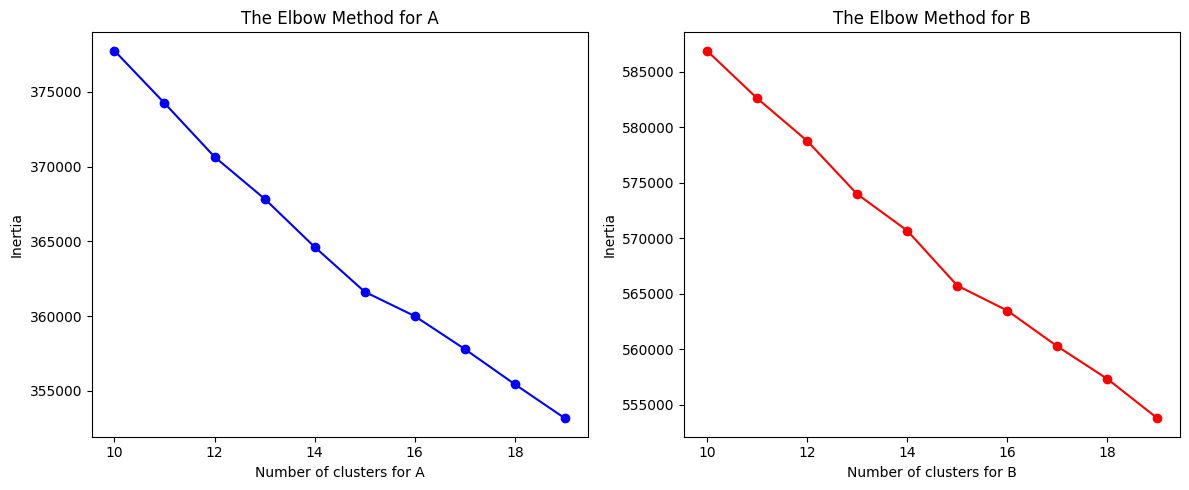

In [ ]:
# A 폴더의 최적의 군집 수 찾기 (Elbow Method)
inertia_A = []
K_range_A = range(10, 20)  # k의 범위는 필요에 따라 조정 가능
for k in K_range_A:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(A_latent_vectors)
    inertia_A.append(kmeans.inertia_)

# B 폴더의 최적의 군집 수 찾기 (Elbow Method)
inertia_B = []
K_range_B = range(10, 20)  # k의 범위는 필요에 따라 조정 가능
for k in K_range_B:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(B_latent_vectors)
    inertia_B.append(kmeans.inertia_)

# A의 Elbow 그래프 그리기
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(K_range_A, inertia_A, 'bo-')
plt.xlabel('Number of clusters for A')
plt.ylabel('Inertia')
plt.title('The Elbow Method for A')

# B의 Elbow 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(K_range_B, inertia_B, 'ro-')
plt.xlabel('Number of clusters for B')
plt.ylabel('Inertia')
plt.title('The Elbow Method for B')

plt.tight_layout()
plt.show()

In [ ]:
#A의 K
elbow_k_A = 20
#B의 K
elbow_k_B = 20


# K-means 알고리즘으로 클러스터링
# 최적의 k 값을 사용하여 K-means 클러스터링 수행
kmeans_A = KMeans(n_clusters=elbow_k_A, random_state=0).fit(A_latent_vectors)
kmeans_B = KMeans(n_clusters=elbow_k_B, random_state=0).fit(B_latent_vectors)

# A, B 폴더의 이미지에 대한 클러스터 라벨 추출
A_cluster_labels = kmeans_A.labels_
B_cluster_labels = kmeans_B.labels_

# A 폴더에서 선택한 이미지의 잠재 벡터
selected_A_index = 0
selected_A_latent_vector = A_latent_vectors[selected_A_index]

# 선택한 이미지와 가장 가까운 B 폴더의 군집 찾기
distances_to_B_clusters = np.linalg.norm(kmeans_B.cluster_centers_ - selected_A_latent_vector, axis=1)
closest_B_cluster = np.argmin(distances_to_B_clusters)

# 가장 가까운 군집에 속한 B 폴더의 이미지 찾기
similar_B_indices = np.where(B_cluster_labels == closest_B_cluster)[0]

# 유사한 상품의 이미지 목록 출력
for idx in similar_B_indices:
    similar_image = B_images_resized[idx]
    similar_image.show()  # 이미지 출력 (옵션)

# 유사한 상품의 파일명 목록 작성
similar_B_filenames = [B_image_files[idx] for idx in similar_B_indices]

# DataFrame으로 변환
df = pd.DataFrame(similar_B_filenames, columns=['Similar_Products'])

from datetime import datetime

# 현재 날짜와 시간을 가져옵니다.

now = datetime.now()

# 년도, 날짜, 시간, 분을 문자열로 포맷팅합니다.
formatted_date = now.strftime("%Y_%m%d_%H%M")

# 파일 이름을 생성합니다.
csv_file_name = f"similar_products({formatted_date}).csv"

# CSV 파일로 저장 (json으로 저장하기)
csv_file_path = f'/content/drive/MyDrive/K-fashion/vector model/B_result/{csv_file_name}'  # 저장할 경로를 지정해주세요.
df.to_csv(csv_file_path, index=False)




/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
